# Replication of Paper - Deep Recurrent Factor Models
This notebooks uses LSTM networks and LRP to examine:

- whether dynamic LSTM models provide a better predictive performance than linear models
- which role different factors play across time in making predictions through a deep LSTM model

## Dependencies

In [4]:
#%% dependencies


# scientific programming
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML and AI
from sklearn.preprocessing import StandardScaler

# os and sys
import sys
sys.path.append("..")  # Add the parent directory to sys.path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # to surpress Tensorflow debugging warnings that arise in jupyter notebooks

# Custom LSTM Model + LRP
from LSTMClass import *
from Preprocessing import process_data_with_factors, prepare_data_for_training

# Plotting and Graphs
import plotly.graph_objects as go

LSTM Load Dependencies: DONE ✔️




## Preprocessing Factor Data

In [5]:
# Define Path to File with factors
file_path = "../Data/PredictorLSretWide.csv"

# Define which factor variables to use
factor_selection = ["betaVIX",
                "Beta",
                "ReturnSkew",
                "RoE",
                "roaq",
                "Accruals",
                "Leverage",
                "Mom12m",
                "SP",
                "EP",
                "AM",
                "cfp",
                "Illiquidity"]

# Produce a data set that includes all factors and the returns
sp500 = process_data_with_factors(file_path, factor_selection)

# Take the data frame and compute a data set of batches of size corresponding to a rolling time-step window of 5
X_train, y_train, X_test, y_test = prepare_data_for_training(data=sp500, small_window_size=5, split_ratio=1)
print("Preprocessing: DONE ✔️")

Download data from yahoo finance ...
[*********************100%***********************]  1 of 1 completed
Download: DONE ✔️
Preprocessing: DONE ✔️


## Build Deep Factor Model Archtecture

In [7]:
# ----------------------------- MODEL CONSTRUCTION ----------------------------------
timesteps = 5
input_dim = len(sp500.columns) - 1
input_shape = (timesteps, input_dim)

input_layer = Input(shape=input_shape, name="Input")
lstm_output2, hidden_state2, cell_state2 = CustomLSTM(units=32, return_sequences=False,
                                                      return_state=True,
                                                      kernel_initializer='glorot_uniform',
                                                      kernel_regularizer=L2(0.01),
                                                      name="CustomLSTM_2")(input_layer)
output_layer = Dense(1, activation='linear', kernel_initializer='glorot_uniform', kernel_regularizer=L2(0.01), name="Dense_2_Final")(lstm_output2)

# Create the model
model = CustomModel(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print the model summary
model.summary()
# ----------------------------- END: MODEL CONSTRUCTION ----------------------------------
print("Creating model architecture: DONE ✔️")

Model: "custom_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 14)]           0         
                                                                 
 CustomLSTM_2 (CustomLSTM)   [(None, 32),              6016      
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
 Dense_2_Final (Dense)       (None, 1)                 33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________
Creating model architecture: DONE ✔️


## Rolling Fit

Model: "custom_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 14)]           0         
                                                                 
 CustomLSTM_2 (CustomLSTM)   [(None, 32),              6016      
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
 Dense_2_Final (Dense)       (None, 1)                 33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________

Starting rolling window fitting...



  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 1/363 [00:05<30:45,  5.10s/it]

100%|██████████| 363/363 [34:39<00:00,  5.73s/it]


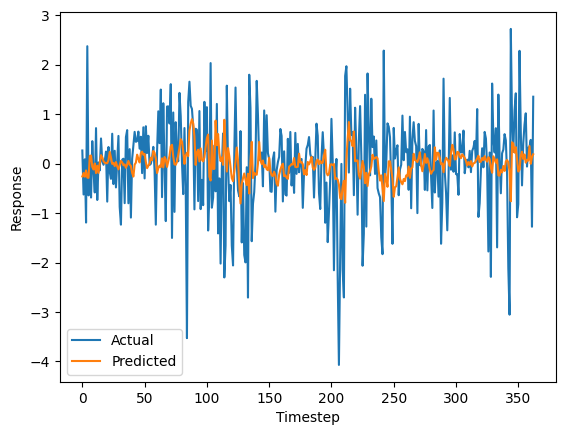

Rolling window fitting completed.
The MSE of the model:	 0.9865298079820659


In [8]:
# Fit rolling lstm model
predictions, relevance = rolling_fit(input_layer=input_layer, output_layer=output_layer,
                                     X_train=X_train, y_train=y_train)

# Compute mse
mse = np.mean((predictions - y_train[60:])**2)

print("The MSE of the model:\t", mse)

# Examine Relevance

In [159]:
# Aggregate and Plot relevance over time
! pip install -U kaleido
all_factor_names = factor_selection + ["ReturnFactor"]

# Aggregate the relevance scores for all timesteps by taking the average
relevance_aggregated = np.mean(np.array(relevance), axis=1)


fig = go.Figure()

x = np.arange(relevance_aggregated.shape[0])  # Assume x-axis values are the same for all line plots

for i in range(relevance_aggregated.shape[1]):
    fig.add_trace(go.Scatter(x=sp500.index[65:], y=relevance_aggregated[:, i], mode='lines', name=(all_factor_names)[i]))
    
    
fig.update_layout(
    title='Relevance across time',
    xaxis_title='Time',
    yaxis_title='Relevance Score',
    legend_title='Lines'
)

fig.show()



import plotly.express as px

fig = px.bar(
    relevance_aggregated,
    x=all_factor_names,
    y=relevance_aggregated.mean(axis=0),
    title="Factor Relevance (averaged over time)",
    labels={"x": "Factor", "y": "Mean Relevance"},
)

fig.show()


![](./static/images/relevance/plot1.png)
![](./static/images/relevance/plot2.png)

In [79]:
# compute the absolute aggregated
abs_relevance_aggregated = abs(relevance_aggregated)

# 
print(abs_relevance_aggregated.shape)
risk = abs_relevance_aggregated[:, 0:3]
quality = abs_relevance_aggregated[:, 3:7]
momentum = abs_relevance_aggregated[:, [7,12]]
value = abs_relevance_aggregated[:, 8:11]
size = abs_relevance_aggregated[:, 11]


abs_group_factor_relevance= np.array([risk.sum(axis=1),
quality.sum(axis=1),
momentum.sum(axis=1),
value.sum(axis=1),
size])



(363, 14)


In [136]:



# Create the figure
fig = go.Figure()
names = ["Risk", "Quality", "Momentum", "Value", "Size"]


for i in range(abs_group_factor_relevance.shape[0]):
    fig.add_trace(go.Scatter(x=sp500.index[65:], y=abs_group_factor_relevance[i, :] /\
                             abs_group_factor_relevance.sum(axis=0),
                             mode='lines', name=names[i],
                             line=dict(width=1)))

fig.update_layout(
    title="Absolute Group Factor Relevance Over Time",
    xaxis_title="Time",
    yaxis_title="Absolute Group Factor Relevance",
    legend_title="Factor Categories"
)

fig.show()

# --- Moving average of factor relevance ---
factor_ts = pd.DataFrame(dict(zip(names, abs_group_factor_relevance /abs_group_factor_relevance.sum(axis=0))))
# Apply a moving average to each column
moving_average_window = 20  # Adjust the window size as needed
factor_ts_ma = factor_ts.rolling(window=moving_average_window).mean()
factor_ts_ma["Date"] = sp500.index[66:]
factor_ts_ma.set_index('Date', inplace=True)
factor_ts_ma.dropna(inplace=True)

# Create the figure
fig = go.Figure()

# Add traces for each column
for column in factor_ts_ma.columns:
    fig.add_trace(go.Scatter(x=factor_ts_ma.index, y=factor_ts_ma[column],
                             mode='lines', name=column))

# Update layout and show the figure
fig.update_layout(
    title="Moving Averages of Absolute Factor Relevance Over Time",
    xaxis_title="Time",
    yaxis_title="% Abs. Relevance",
    legend_title="Factor Categories"
)

fig.show()



# --- Median Factor Relevance across time ---
abs_relevance_grouped = np.array([np.median(risk.sum(axis=1)),
                                  np.median(quality.sum(axis=1)),
                                  np.median(momentum.sum(axis=1)),
                                  np.median(value.sum(axis=1)),
                                  np.median(size)])


fig = px.bar(
    x=["Risk", "Quality", "Momentum", "Value", "Size"],
    y=abs_relevance_grouped / abs_relevance_grouped.sum(),
    title='Median Percentage of Relevance by Factor Category',
    color=["Risk", "Quality", "Momentum", "Value", "Size"]
    
)
fig.update_layout(
    xaxis_title = "Factor Category",
    yaxis_title = "% Abs. Relevance"
)
fig.show()

![](./static/images/relevance/plot3.png)
![](./static/images/relevance/plot4.png)
![](./static/images/relevance/plot6.png)

# Fit a Rolling Linear Regression

In [131]:
# Define Path to File with factors
file_path = "../Data/PredictorLSretWide.csv"

# Define which factor variables to use
factor_selection = ["betaVIX",
                "Beta",
                "ReturnSkew",
                "RoE",
                "roaq",
                "Accruals",
                "Leverage",
                "Mom12m",
                "SP",
                "EP",
                "AM",
                "cfp",
                "Illiquidity"]

# Produce a data set that includes all factors and the returns
sp500 = process_data_with_factors(file_path, factor_selection)


# Create lagged versions of the factors (lags 1, ..., lag 5)
lags = range(1, 2)

# save the old columns
old_columns = sp500.columns

# iterate over all columns and create 5 lags as new columns
for col in sp500.columns:
    for lag in lags:
        sp500[f'{col}_lag{lag}'] = sp500[col].shift(lag)

# remove contemporary features since we are intersted in predicting future returns by means of lag1, ..., lag5
sp500.drop(columns=old_columns[old_columns != "Return"], inplace=True)


Download data from yahoo finance ...
[*********************100%***********************]  1 of 1 completed
Download: DONE ✔️


/tmp/ipykernel_610303/1009411061.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 365/365 [00:01<00:00, 269.40it/s]


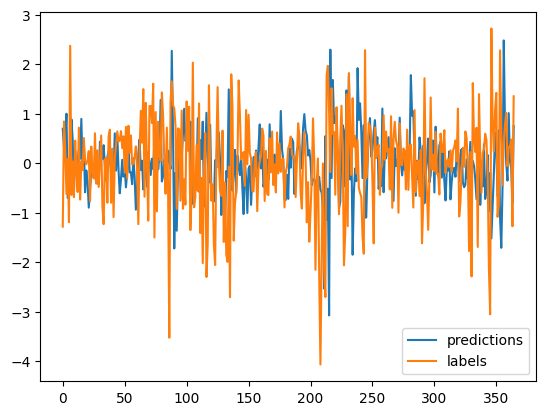

In [132]:
# import linear regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# define the data to train on - start from index 4 to make a comparison with LSTM model that can only use the same data
data = sp500.iloc[4:, :]

# Drop rows with NaN values introduced by shifting
data.dropna(inplace=True)

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


# Define the window size for the rolling regression
window_size = 60

# Perform the rolling regression
results = []
predictions = []
for i in tqdm(range(len(data) - window_size)):
    #print("i:i+window_size = ", i, i+window_size)
    window_data = data.iloc[i:i+window_size]
    model = sm.OLS(window_data.iloc[:, 0], window_data.iloc[:, 1:])
    result = model.fit()
    results.append(result)
    predictions.append(result.predict(data.iloc[i+window_size, 1:]))
    
plt.plot(np.array(predictions), label="predictions")
plt.plot(np.array(data.Return[60:]), label="labels")
plt.legend()

In [133]:
mse = np.mean((np.array(predictions) - np.array(data.Return[60:]))**2)
print("The MSE for the rolling regression:", mse)

The MSE for the rolling regression: 1.3325577354013924


We observe that the 'Deep Recurrent Factor Model' exhibits a higher predictive performance in terms of MSE 
than the linear factor model. Interestingly, throughout the considered time-period (1991-07-31 - 2021-10-31), the relevance scores of the LSTM model suggest that Quality, Risk and Value are the most relevant features when predicting returns within that period. In the moving average plot above one can observe that the average factor relevance changes over time and does not stay constant. Keeping our highly sibjective factor choice into account, the factors size and momentum do not seem to take precedence over the the other factor. 

We look at the time-frame considered in the paper [*Deep Recurrent Factor Model: Interpretable Non-Linear and Time-Varying
Multi-Factor Model*](https://arxiv.org/pdf/1901.11493.pdf), i.e. from 1990-2015. Unfortunately, we only have access to data fram 1991 onwards, we will still make an attempt to analyse the same time frame in an effort to make some sort of comparison between the US and the Japanese stock market throughout this period.





In [142]:

# Create the figure
fig = go.Figure()

filtered_df = factor_ts_ma[factor_ts_ma.index <= '2015-03-31']

# Add traces for each column
for column in filtered_df.columns:
    fig.add_trace(go.Scatter(x=filtered_df.index, y=filtered_df[column],
                             mode='lines', name=column))

# Update layout and show the figure
fig.update_layout(
    title="Moving Averages of Absolute Factor Relevance Over Time: 1991 - 2015",
    xaxis_title="Time",
    yaxis_title="% Abs. Relevance",
    legend_title="Factor Categories"
)

fig.show()




fig = px.bar(
    x=["Risk", "Quality", "Momentum", "Value", "Size"],
    y=filtered_df.apply(np.median, axis=0),
    title='Median Percentage of Relevance by Factor Category: 1991 - 2015',
    color=["Risk", "Quality", "Momentum", "Value", "Size"]
    
)
fig.update_layout(
    xaxis_title = "Factor Category",
    yaxis_title = "% Abs. Relevance"
)
fig.show()

![](./static/images/relevance/plot7.png)
![](./static/images/relevance/plot8.png)

In comparison to  [*Deep Recurrent Factor Model: Interpretable Non-Linear and Time-Varying
Multi-Factor Model*](https://arxiv.org/pdf/1901.11493.pdf), our model, based on the SP500 stock market index, suggests 
that Quality, Value and Risk seem to be the most relvant predictors for future returns. However, the paper suggest that for the Japanese stock market, assessed based on the example of the TOPIX500 stock market index, the most important factors are Value, Size and Quality (in that order). This provides ground for further analysis as there could be many reasons why this descrepancy arises. We do not exlcude the possibility that our factor data quality is insufficient. But, perhaps there is a inherent difference on how market participants preceive differnt stock markets around the world and use different metrics and factors to make investment decision. At this point we cannot make a conclusive statement on whether this is truly the case or not.